# Loan Repayment Challenge


Loan lending has been an important business activity for both individuals and financial institutions. Profit and loss of financial lenders to an extent depend on loan repayment. Though loan lending is beneficial for both lenders and borrowers, it does carry a great risk of the inability of the loan receiver to repay back the loan. This inability is termed as loan default. Loan default prediction is a crucial process that should be carried out by financial lenders to help them find out if a loan can default or not. Successful loan default prediction can help financial institutions to decrease the number of bad loan issues and eventually increase profit.

Throughout the years, machine learning algorithms have been used to calculate and predict credit risk by evaluating an individual’s historical data. Literally, this can be locally controlled by following these measures.

1. Credit analysis of potential borrowers should be carried out in order to judge the credit risk associated with the borrower and to reach a lending decision.
2. Loan repayments should be monitored and whenever a customer defaults, action should be taken. Thus lender should avoid loans to risky customers, monitor loan repayments, and renegotiate loans when customers get into difficulties.
3. Bad loans can be restricted by ensuring that loans are made to only borrowers who are likely to be able to repay, and who is unlikely to become insolvent.

From business context, we want to reduce the number of bad loan which lead to a loss for the lender. Although from the give dataset, each row represents an accepted loan application or a successfully funded loan. But these loans could still possibly be defaulted by the borrower. Solving this problem can help the lender to identify the loan with higher chance of defaulting and necessary action can be taken in advance.

For this assessment, we want to predict which loan has the high probability of being default based on their financial information and payment history. Hence, we only consider about the funded loan.

# Load Libraries & Gather Data

First, we import the necessary libraries and data.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


loan = pd.read_csv('data//data//loan.csv', parse_dates=['applicationDate', 'originatedDate'])
score = pd.read_csv("data//data//clarity_underwriting_variables.csv")
payment = pd.read_csv('data//data//payment.csv', parse_dates=['paymentDate'])

Since, we are predicting the risk of the funded loan, hence we only consider the funded loan and remove the non-funded loan.

In [2]:
df = loan[loan['isFunded'] == 1].copy()
df = df.drop(['isFunded'], axis=1)

Now, we want to gather the data from the clarity file. We join the loan data with the clarity data to obtain the clearfraudscore. In this situation, we use left join on loan.clarityFraudId = clarity.underwritingid.

In [3]:
df = df.merge(score[['underwritingid', 'clearfraudscore']],
                left_on='clarityFraudId',
                right_on='underwritingid',
                how='left')
df = df.drop(['underwritingid', 'clarityFraudId'], axis=1)

Next, we want to gather the data from the payment file. First, we have to modify the paymentStatus. The best tool in this situation is the pivot_table function. We count how many time each payment status occur in each loan identified by loanId.

In [4]:
payment['val'] = 1
payment_status = payment.pivot_table(index=['loanId'], columns=['paymentStatus'], values='val', aggfunc=sum, fill_value=0)
payment_status.head()

paymentStatus,Cancelled,Checked,Complete,None,Pending,Rejected,Rejected Awaiting Retry,Returned,Skipped
loanId,,,,,,,,,
LL-I-00000021,0,12,0,0,0,1,0,0,0
LL-I-00000231,8,2,0,8,0,2,0,0,0
LL-I-00000238,4,7,0,4,0,1,0,0,0
LL-I-00000308,10,1,0,10,0,1,0,0,0
LL-I-00000355,11,0,0,11,0,1,0,0,0


Next, we check the number of occurence for each payment status.

In [5]:
payment_status.sum()

paymentStatus
Cancelled                  270334
Checked                    209621
Complete                        1
None                       164057
Pending                      9241
Rejected                    32330
Rejected Awaiting Retry        18
Returned                        1
Skipped                      3761
dtype: int64

We found out that Complete and Returned status has only 1 occurence each and these status are not explained in the documentation. Hence, I decided to drop them. Then we join the main data and the payment status data using loanId and left join.

In [6]:
payment_status = payment_status.drop(['Complete','Returned'], axis=1)
df = df.merge(payment_status, on='loanId', how='left')
# df.head()

Next, similar with payment status, we count how many time does collection payment occur in each loan identified by loanId. Then we join the main data and the collection status data using loanId and left join.

In [7]:
collection_status = payment.pivot_table(index=['loanId'], columns=['isCollection'], values='val', aggfunc=sum, fill_value=0)
collection_status.columns = ['not_collection_count', 'collection_count']

df = df.merge(collection_status, on='loanId', how='left')
# df.head()

Next, want to obtain the installment amount for each loan. To obtain the value, we select the most frequency payment amount for each loan identified by loanId. Then we join the main data and the installment amount data using loadId and left join.

In [8]:
installment_amount = payment.groupby(['loanId'])['paymentAmount'].agg(lambda x: x.value_counts().index[0]).astype('float').to_frame()
installment_amount.columns = ['installment_amount']

df = df.merge(installment_amount, on='loanId', how='left')
# df.head()

Until now, the data gathering and preparation step is done. Since, the loan status is our final target, we check the occurence of each loan status.

In [9]:
df['loanStatus'].value_counts()

Paid Off Loan                  11427
External Collection            11334
New Loan                        8112
Internal Collection             5564
Returned Item                   1182
Settlement Paid Off              708
Settled Bankruptcy               325
Pending Paid Off                 169
Charged Off Paid Off             159
Charged Off                        1
Settlement Pending Paid Off        1
Name: loanStatus, dtype: int64

Since our final target is to predict if the loan is a good loan or bad loan. We have to modify the loan status and convert the problem into a binary classification problem. So the question here is, WHAT DEFINES A GOOD LOAN AND A BAD LOAN?

Since I am not an expert in this area and I'm not sure what does each status mean. Hence, I tried to google them and I list down the defination that I got and try to categorize them.


Class 0: Good Loan
1. Paid Off Loan : Loan that has been paid off.
2. Settlement Paid Off : Loan that has been settled or paid off earlier.

Class 1: Bad Loan
1. External/Internal Collection : Collection is when a collection agency (internal/external) collects the past-due debts from borrowers.
2. Settled Bankruptcy : Loan that has been settled or paid off after bankruptcy.
3. Charged Off Paid Off : Charged off loan that has been paid off. (creditor has written the account off as a loss and closed the account)
4. Charged Off : Creditor has written the account off as a loss and closed the account.

Class 2: Neutral Loan (To be ignored)
1. New Loan : A completely new loan
2. Returned Item : Missed 1 payment (but not more) due to insufficient funds.
3. Pending Paid Off : Loan waiting to be paid off.
4. Settlement Pending Paid Off : Settlement loan waiting to be paid off.


In [10]:
target_dict = {
    'External Collection' : 1, 
    'Internal Collection' : 1, 
    'Charged Off Paid Off' : 1, 
    'Settled Bankruptcy' : 1, 
    'Charged Off' : 1,                      # Bad Loan
    'Paid Off Loan' : 0, 
    'Settlement Paid Off': 0,               # Good Loan
    'New Loan' : 2, 
    'Returned Item' : 2, 
    'Pending Paid Off' : 2, 
    'Settlement Pending Paid Off': 2       # Neutral Loan, will be dropped out later
}


df = df.replace({'loanStatus': target_dict})
df = df[df['loanStatus'] != 2]

After replacing the loan status and dropping the neutral loan, let's look at the number and distribution of the loan status.

Number of good loan = 12135
Percentage of good loan = 41.11%
Number of bad loan = 17383
Percentage of bad loan = 58.89%


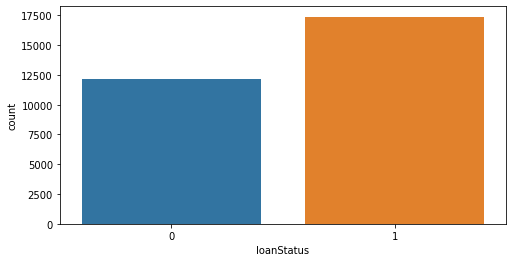

In [11]:
goodloan = df[df['loanStatus'] == 0].shape[0]
badloan = df[df['loanStatus'] == 1].shape[0]
print(f"Number of good loan = {goodloan}")
print(f"Percentage of good loan = {round(goodloan / df.shape[0] * 100, 2)}%")
print(f"Number of bad loan = {badloan}")
print(f"Percentage of bad loan = {round(badloan / df.shape[0] * 100, 2)}%")

plt.figure(figsize=(8, 4))
sns.countplot(df['loanStatus'])
plt.show()

From the numbers and graph above, we found out that we have 12135 good loans (41.11%) and 17382 bad loans (58.89%). Although the difference is lesser than I thought (I thought there will be more good loan than bad loan hmmmm), but it is still a slightly imbalanced dataset. We could apply some technique like upsampling or downsampling to deal with the imbalanced data, but since the difference is not too much, so we will remain as it is.

# Exploratory Data Analysis

First, we check the missing value as usual.

In [12]:
df.isnull().sum()

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originated                             0
originatedDate                         0
nPaidOff                              21
approved                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               8
hasCF                                  0
clearfraudscore                     5116
Cancelled                             14
Checked                               14
None                                  14
Pending                               14
Rejected                              14
Rejected Awaiting Retry               14
Skipped         

From the result above, we have 21 missing values in nPaidOff, 8 missing values in fpStatus, 5116 missing values in clearfraudscore (17.33%), and 14 missing values in all the payment status caused by the left join. For nPaidOff and fpStatus, we have less missing values and we can replace the missing value with the mode value. For all the payment status, since they have missing value in all the payment status caused by left join and the number is less, so we can just drop them. But for clearfraudscore, it is logically an very importance feature for the model, hence we have to treat it carefully. We will deal with it afterward.

In [13]:
df = df.dropna(subset=['Cancelled'], how='any').reset_index(drop=True)
df['nPaidOff'] = df['nPaidOff'].fillna(0)
df['fpStatus'] = df['fpStatus'].fillna('Checked')

df.isnull().sum()

loanId                                 0
anon_ssn                               0
payFrequency                           0
apr                                    0
applicationDate                        0
originated                             0
originatedDate                         0
nPaidOff                               0
approved                               0
loanStatus                             0
loanAmount                             0
originallyScheduledPaymentAmount       0
state                                  0
leadType                               0
leadCost                               0
fpStatus                               0
hasCF                                  0
clearfraudscore                     5103
Cancelled                              0
Checked                                0
None                                   0
Pending                                0
Rejected                               0
Rejected Awaiting Retry                0
Skipped         

Let's explore the data and see what we can derive from it. First, let's us quickly look at the summary of the data using sweetviz which is a quick auto EDA library.

In [14]:
import sweetviz


my_report = sweetviz.analyze(df.drop(['loanId','anon_ssn','applicationDate','originated','originatedDate','approved'],axis=1), target_feat="loanStatus")
my_report.show_html('FinalReport.html')

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report FinalReport.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


From the report (FinalReport.html), we could see that most of our data are skewed, eg. apr, nPaidOff, loanAmount, originallyScheduledPaymentAmount, leadCost, clearfraudscore, collection_count, not_collection_count, and installment_amount. Skewed data degrades the model’s ability (especially regression based models) to describe typical cases as it has to deal with rare cases on extreme values. ie right skewed data will predict better on data points with lower value as compared to those with higher values. Skewed data also does not work well with many statistical methods. However, tree based models are not affected.

Method dealing with skew data:
1. Log transformation
2. Remove outliers
3. Normalize (min-max)
4. Cube root or Square root
5. Reciprocal
6. Square
7. Box Cox transformation

But since we are using tree based models in our modelling step, we are not going to perform any transformation.

Furthermore, we could look at how each of the variable infleunce our target variable by looking at the line for each chart in every variable. It's interesting to see that how the values in each variables influence our target variable. To further deep dive into them, we have to do it ourselves. So let's get started.


First, we check the distribution of the clearfraudscore.

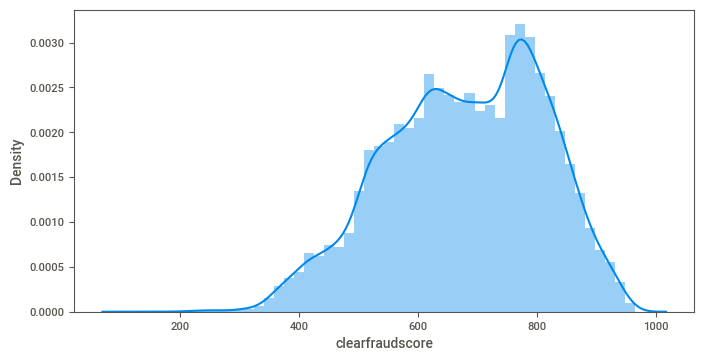

In [15]:
plt.figure(figsize=(8, 4))
sns.distplot(df['clearfraudscore'])
plt.show()

From the distribution graph above, we could see that the density is higher around 600-800, meaning that clearfraudscore is a left skewed variable. Let's see how clearfraudscore varies for each loan status using boxplot.

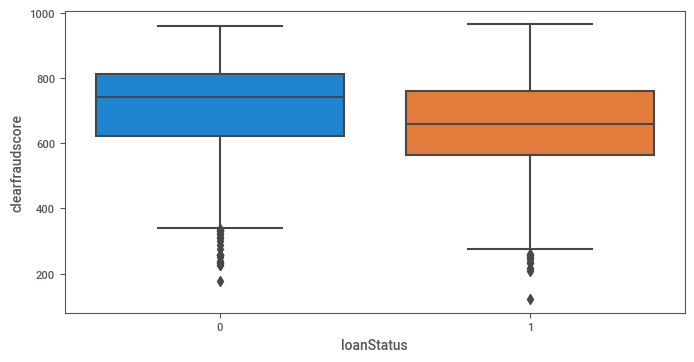

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='loanStatus', y='clearfraudscore', data=df)
plt.show()

From the boxplot graph above, we could see that there are just a slight difference between the good loan and the bad loan. The upper quartile, median, lower quartile and minimum value in the bad loan are lower compare to the good loan. But both boxes have lots of overlapping, hence we cannot conclude the loan status using clearfraudscore and have to take another step to reach any conclusion.

Next we will take a look at the countplot of pay frequency distinguised by loan status.

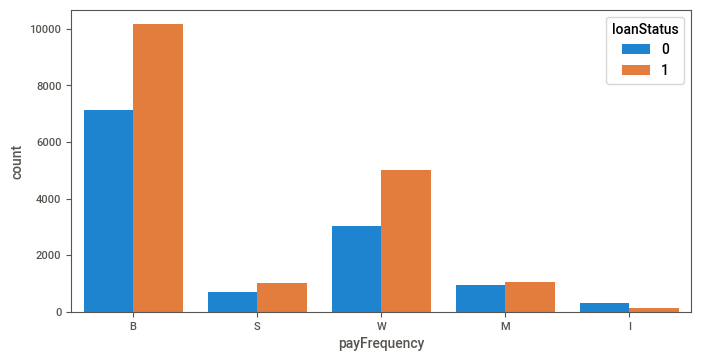

In [17]:
plt.figure(figsize=(8, 4))
sns.countplot(x="payFrequency", hue="loanStatus", data=df)
plt.show()

From the graph above, we could see that biweekly payment and weekly payment has more bad loan than good loan. But why is it happening? Is biweekly payment and weekly payment has higher apr? Let's take a look at it.

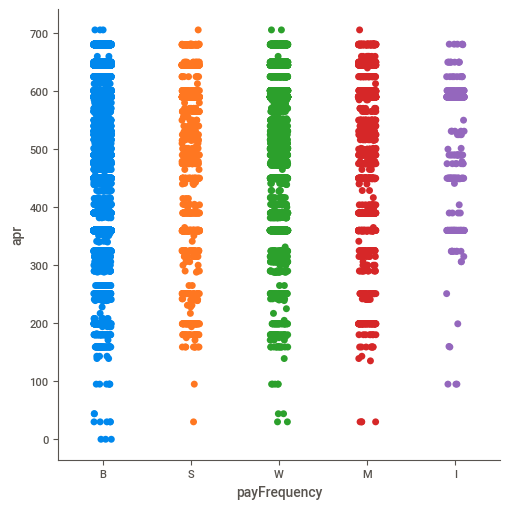

B  :  526.73
S  :  513.27
W  :  539.35
M  :  513.03
I  :  502.01


In [18]:
sns.catplot(y="apr", x="payFrequency", data=df)
plt.show()

for x in df['payFrequency'].unique():
    print(x, " : ", round(df[df['payFrequency'] == x]['apr'].mean(),2))

From the graph and value above, we could see that biweekly payment and weekly only has only a very slight higher apr. Hence, our hypothesis is wrong.

Next, let's take a look at the distribution of clearfraudscore for each payment frequency.

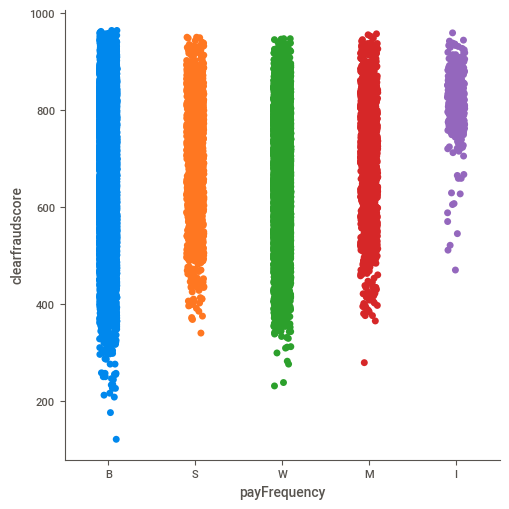

B  :  676.09
S  :  710.16
W  :  668.35
M  :  713.19
I  :  810.05


In [19]:
sns.catplot(y="clearfraudscore", x="payFrequency", data=df)
plt.show()

for x in df['payFrequency'].unique():
    print(x, " : ", round(df[df['payFrequency'] == x]['clearfraudscore'].mean(), 2))

From the graph and value above, we could see that biweekly payment and weekly payment loan has a lower clearfraudscore. Hence, it might be the cause of them having more bad loan than good loan.

Next, we will take a look at the boxplot of apr distinguised by loan status.

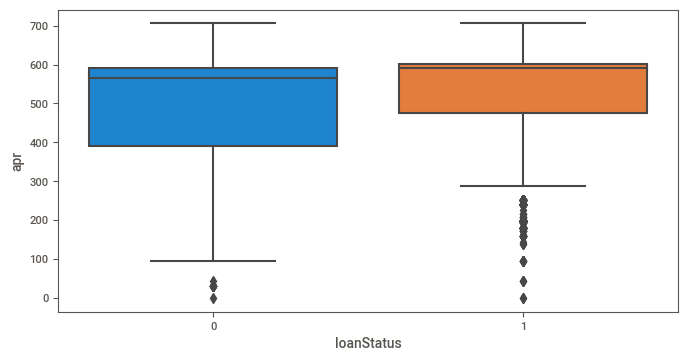

In [20]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='loanStatus', y='apr', data=df)
plt.show()

From the boxplot graph above, we could see that there are just a slight difference between the good loan and the bad loan. The upper quartile, median, lower quartile and minimum value in the bad loan are higher compare to the good loan.

Next we will take a look at the catplot of number of paid of loan distinguised by loan status.

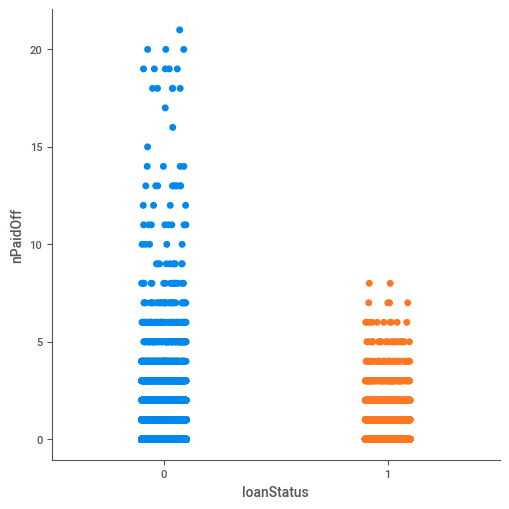

In [21]:
sns.catplot(y="nPaidOff", x="loanStatus", data=df)
plt.show()

From the catplot graph above, we could see that loan with higher number of paid off loan is usually a good loan. Both loans have most number of paid off loan around 0-5.

From the sweetviz report, we could see that the loan amount has higher density around 200-1000, meaning that loan amount is a right skewed variable. Let's see how loan amount varies for each loan status.

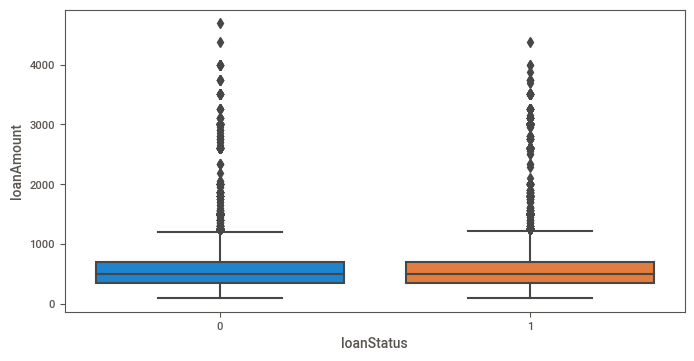

In [22]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='loanStatus', y='loanAmount', data=df)
plt.show()

From the boxplot graph above, we could see that both boxes don't have obvious difference. Hence we have to take another step to reach any conclusion.

Next we will take a look at the countplot of state distinguised by loan status.

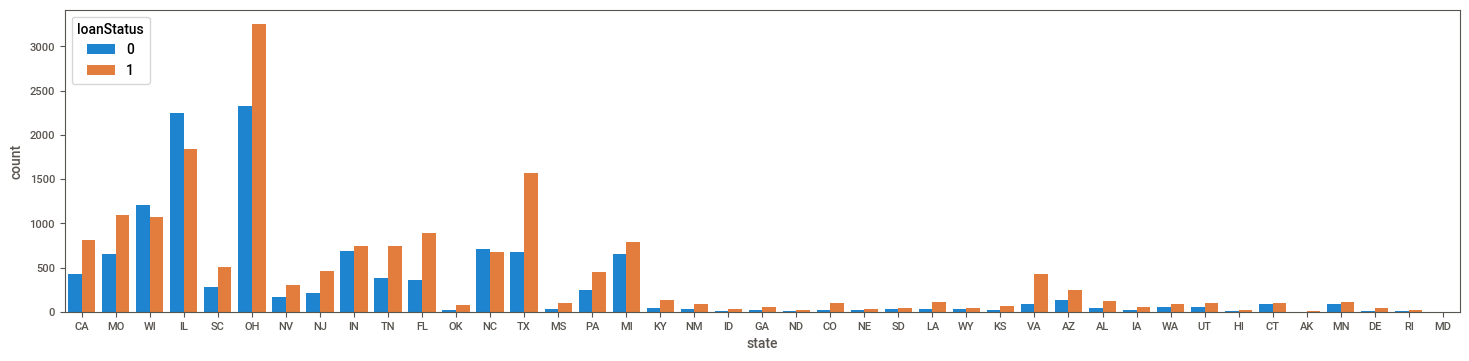

In [23]:
plt.figure(figsize=(18, 4))
sns.countplot(x="state", hue="loanStatus", data=df)
plt.show()

From the graph above, it is interesting to see that some state such as OH, IL, TX, MO, WI have more bad loan compare to other state. Maybe we can reconsider and stricten the loaning rules in these state to reduce the number of bad loan?

Let's list out the state that have more bad loan than the good loan.

In [24]:
badstate = []

for x in df['state'].unique():
    if len(df[(df['state'] == x) & (df['loanStatus'] == 0)]) < len(df[(df['state'] == x) & (df['loanStatus'] == 1)]):
        badstate.append(x)

print(f'State that has higher number of bad loan than the good loan: \n{badstate}')

State that has higher number of bad loan than the good loan: 
['CA', 'MO', 'SC', 'OH', 'NV', 'NJ', 'IN', 'TN', 'FL', 'OK', 'TX', 'MS', 'PA', 'MI', 'KY', 'NM', 'ID', 'GA', 'ND', 'CO', 'NE', 'SD', 'LA', 'WY', 'KS', 'VA', 'AZ', 'AL', 'IA', 'WA', 'UT', 'HI', 'CT', 'AK', 'MN', 'DE', 'RI']


Next we will take a look at the countplot of lead type distinguised by loan status.

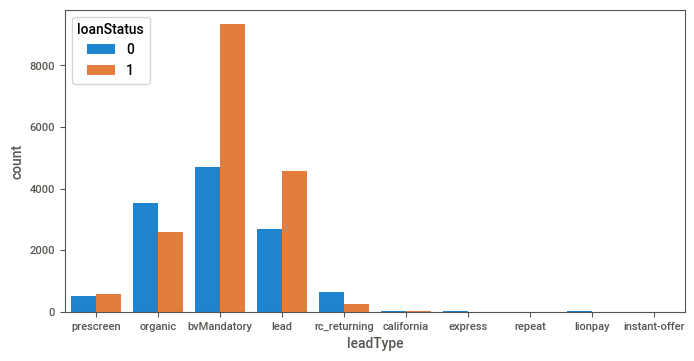

In [25]:
plt.figure(figsize=(8, 4))
sns.countplot(x="leadType", hue="loanStatus", data=df)
plt.show()

From the graph above, it is interesting to see that bvMandatory and lead have more bad loan compare to other lead type. But my assumption is, I don't think leadType will affect the model a lot. Let's see how it goes.

Lastly, we will take a look at the countplot of fpStatus distinguised by loan status.

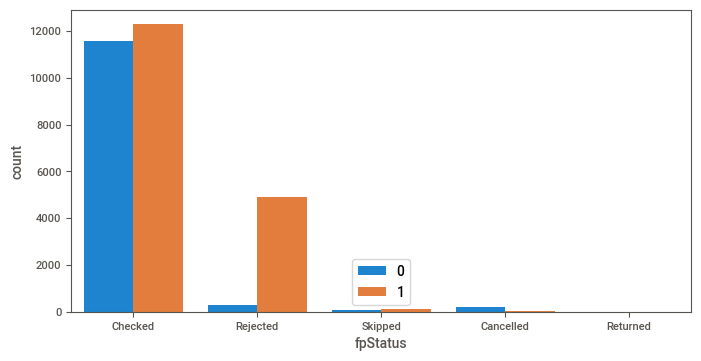

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(x="fpStatus", hue="loanStatus", data=df)
plt.show()

From the graph above, we can conclude that usually loan that has a rejected first payment has a higher probability to become a bad loan.

From the short exploratory data analysis above, we could generate some quick insights.

1. The clearfraudscore is lower in the bad loan but we cannot conclude using it since there are lots of overlapping.
2. Biweekly payment and weekly payment has higher number of bad loan.
3. Bad loan usually has higher apr.
4. Loan with higher number of paid off loan is usually a good loan
5. Some state such as OH, IL, TX, MO, WI have more bad loan compare to other state.
6. Lead type == bvMandatory and lead have more bad loan compare to other lead type.
7. Loan that has a rejected first payment usually has a higher probability to become a bad loan.

These are just a quick insights. We can dive deep into the number furthermore if required.

# Feature Engineering

After exploring the data, now we can start the feature engineering step. First, we create and derive new features to provide more informations to our model.

In [27]:
df['loan_count'] = df['anon_ssn'].map(df.groupby('anon_ssn')['loanId'].count()).astype(int)
df['paid_off_loan_count'] = df['anon_ssn'].map(df.groupby('anon_ssn')['nPaidOff'].sum()).astype(int)
df['time_taken_to_originate'] = (df['originatedDate'] - df['applicationDate']).astype('timedelta64[h]').astype(int)
df['interest_amount'] = df['originallyScheduledPaymentAmount'] - df['loanAmount']

Then, we use LabelEncoder to encoder our catagorical value into numerical value.

In [28]:
from sklearn.preprocessing import LabelEncoder


encode_column = ['payFrequency','state','leadType','fpStatus']

for column in encode_column:
    encoder = LabelEncoder()
    df[f"{column}_encoded"] = encoder.fit_transform(df[column])

Then, we remove the unused column.

In [29]:
unused_column = ['loanId','anon_ssn', 'applicationDate', 'originated', 'originatedDate', 'approved']

df = df.drop(encode_column + unused_column, axis=1)

Now, it's the time to deal with the missing value in the clearfraudscore. Since clearfraudscore is obviously one of the important feature that will directly affect the model, hence we have to treat it carefully. In this situation, I choose to use the KNNImputer that use KNN algorithm to predict the missing clearfraudscore.

In [30]:
from sklearn.impute import KNNImputer


imputer = KNNImputer()
df_final = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_final.isnull().sum()

apr                                 0
nPaidOff                            0
loanStatus                          0
loanAmount                          0
originallyScheduledPaymentAmount    0
leadCost                            0
hasCF                               0
clearfraudscore                     0
Cancelled                           0
Checked                             0
None                                0
Pending                             0
Rejected                            0
Rejected Awaiting Retry             0
Skipped                             0
not_collection_count                0
collection_count                    0
installment_amount                  0
loan_count                          0
paid_off_loan_count                 0
time_taken_to_originate             0
interest_amount                     0
payFrequency_encoded                0
state_encoded                       0
leadType_encoded                    0
fpStatus_encoded                    0
dtype: int64

After we successfully predict the missing clearfraudscore, we check the distribution again to see if the prediction has affected the original distribution.

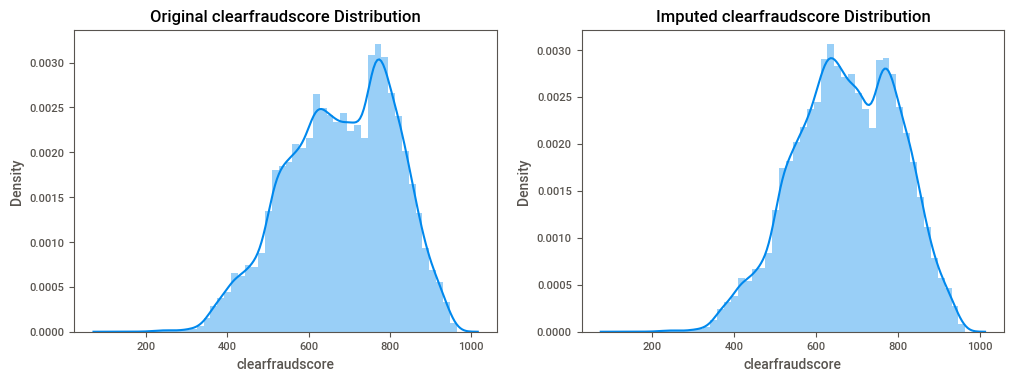

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
sns.distplot(df['clearfraudscore'], ax=axs[0])
sns.distplot(df_final['clearfraudscore'], ax=axs[1])
axs[0].set_title('Original clearfraudscore Distribution')
axs[1].set_title('Imputed clearfraudscore Distribution')
plt.show()

From the distribution figure above, we can see that the distribution has been slightly affected. Next, we check the boxplot.

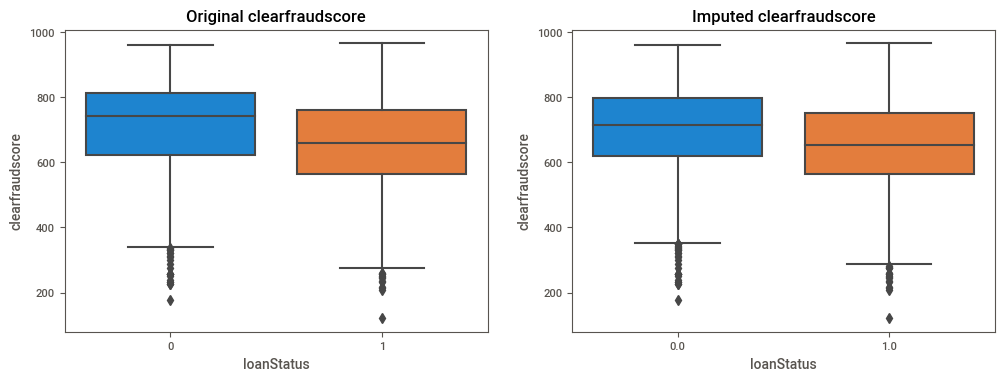

In [32]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
sns.boxplot(x='loanStatus', y='clearfraudscore', data=df, ax=axs[0])
sns.boxplot(x='loanStatus', y='clearfraudscore', data=df_final, ax=axs[1])
axs[0].set_title('Original clearfraudscore')
axs[1].set_title('Imputed clearfraudscore')
plt.show()

Although the distribution has been affected, but from the boxplot graph above, we could see that the original information is not affected too much. KNNImputer has did a great job.

Next, we look at the correlation between the column.

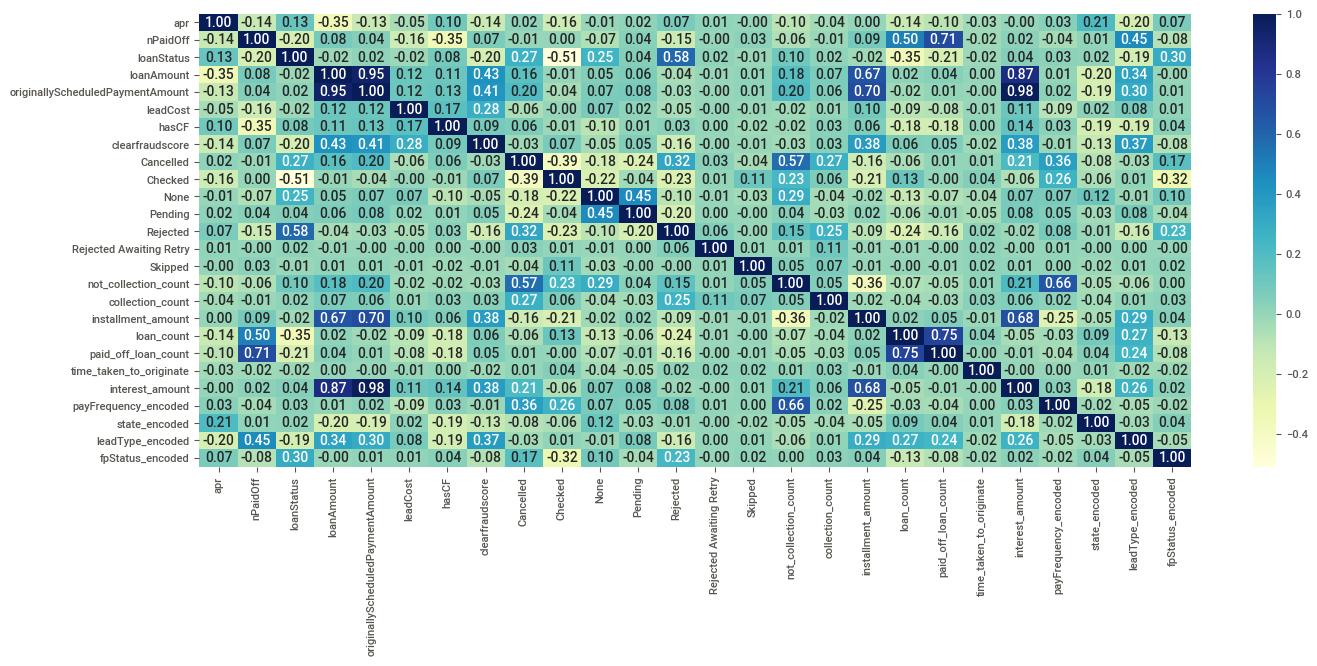

In [33]:
plt.figure(figsize=(16, 6))
sns.heatmap(df_final.corr(), annot=True, fmt='.2f', cmap='YlGnBu')
plt.show()

From the correlation heatmap above, we found out that loanAmount, interest_amount and originallySchedulePaymentAmount are highly correlated. Since correlated features don't improve model, we could remove the highly correlated features by using Pearson Correlation to increase model efficiency.

Or we could just let the model to decide and remove the dedundant feature such as pruning in decision tree.

In [34]:
# Function selecting highly correlated features, it will remove the first feature that is correlated with anything other feature
def correlation(dataset, threshold):
    col_corr = set()                                        # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:     # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]            # getting the name of column
                col_corr.add(colname)
    return col_corr


corr_features = correlation(df_final, 0.8)
corr_features

{'interest_amount', 'originallyScheduledPaymentAmount'}

In [35]:
df_final = df_final.drop(corr_features, axis=1)

# Modelling

As usual, we split the data into 70% of training data and 30% of testing data.

In [36]:
from sklearn.model_selection import train_test_split


x = df_final.drop(['loanStatus'], axis=1).copy()
y = df_final['loanStatus'].copy()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

Now, we are ready to build and train the model. To solve this problem, we are going to use ensemble learning and tree-based model.

Ensemble Learning
1. Bagging and boosting are both ensemble learning methods in machine learning, where a set of weak learners are combined to create a strong learner that obtains better performance.
2. The basic idea behind ensemble learning is to learn a set of classifiers (experts) and to allow them to vote. This diversification in machine learning is achieved by a technique called ensemble learning.
3. These methods are designed to improve the stability and the accuracy of machine learning algorithms. Combinations of multiple classifiers decrease variance, especially in the case of unstable classifiers, and may produce a more reliable classification than a single classifier.

Bagging (Random Forest)
1. Bagging is a parallel process. It is a simple and powerful ensemble method. Bagging is the application of the bootstrap procedure to a high-variance machine learning algorithm.
2. The idea behind bagging is combining the results of multiple models (for instance, all decision trees) to get a generalized result.
3. Bagging technique uses subsets (bags) to get a fair idea of the distribution (complete set). The size of subsets created for bagging may be less than the original set.

Boosting (XGBoost)
1. Boosting is a sequential process, where each subsequent model attempts to correct the errors of the previous model. The succeeding models are dependent on the previous model.
2. In this technique, learners are learned sequentially with early learners fitting simple models to the data and then analyzing data for errors. In other words, we fit consecutive trees (random sample) and at every step, the goal is to solve for net error from the prior tree.
3. When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. By combining the whole set at the end converts weak learners into better performing model.

The reasons we choose tree-based ensemble learning algorithm to solve our problem are
1. Ensemble learning algorithm helps to improve machine learning model performance by combining several models that allow the production of better predictive performance compared to a single model.
2. Tree-based models are not sensitive to outliers, missing data, and skewness.
3. Tree-based models are more interpretable.

### Bagging (Random Forest)

First, we try a simple random forest classifier with default parameter and we use roc_auc score as scoring method.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


rf_clf = RandomForestClassifier(random_state=0)
print("Random forest training roc_auc_score: ", round(cross_val_score(rf_clf, x_train, y_train, scoring='roc_auc', cv=10).mean() * 100, 2), "%")

Random forest training roc_auc_score:  98.61 %


Unexpectedly, We achieve 98.61% of roc_auc score using cross validation with cv = 10 in our first try.

Next, we try to tune the hyperparameters using randomized search cv to see whether we can get a better model. Below are some of the hyperparameters that we can explore.

In [38]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in range(50, 500, 50)]             # Number of trees in random forest
max_features = ['auto', 'sqrt', 'log2']                         # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]      # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10]                                  # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4]                                    # Minimum number of samples required at each leaf node
bootstrap = [True, False]                                       # Method of selecting samples for training each tree

rf_param = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}


rf_clf = RandomForestClassifier(random_state=0)
rf_random_cv = RandomizedSearchCV(estimator=rf_clf, param_distributions=rf_param, n_iter=10, cv=5, verbose=2, random_state=0, n_jobs=-1)
rf_random_cv.fit(x_train, y_train)
rf_random_cv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                       min_samples_split=10, n_estimators=350, random_state=0)

In [39]:
rf_clf = RandomForestClassifier(bootstrap=False, max_depth=20, max_features='sqrt',
                                min_samples_split=10, min_samples_leaf=1, n_estimators=350, random_state=0)

print("Random forest best training roc_auc_score: ", round(cross_val_score(rf_clf, x_train, y_train, scoring='roc_auc', cv=10).mean() * 100, 2), "%")

Random forest best training roc_auc_score:  98.72 %


By using the best hyperparameters, the model achieve a 98.72% roc_auc score. ( 98.61% before hyperparameter tuning, at least we tried :) )

Next, we are going to evaluate it using the test set to get the model performance.

First, let's us define the model performance evaluation metric.

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score ,classification_report


def model_performance(true_labels, predicted_labels, classes, title='Confusion Matrix'):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    
    print("Accuracy: ", round(accuracy * 100, 2), "%")
    print("Precison: ", round(precision * 100, 2), "%")
    print("Recall: ", round(recall * 100, 2), "%")
    print("F1 Score: ", round(f1 * 100, 2), "%")
    print("ROC_AUC: ", round(roc_auc * 100, 2), "%")
    
    print("\nModel Report: ")
    print(classification_report(true_labels, predicted_labels))

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    df_cm = pd.DataFrame(conf_matrix, index=classes, columns=classes)
    print("Confusion Matrix: ")
    plt.figure(figsize=(8, 4))
    ax = plt.subplot()
    sns.heatmap(df_cm, annot=True, cmap=plt.get_cmap('Blues'), ax=ax, fmt='g')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    
    return accuracy, precision, recall, f1, roc_auc


Accuracy:  94.15 %
Precison:  94.47 %
Recall:  95.76 %
F1 Score:  95.11 %
ROC_AUC:  93.77 %

Model Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93      3592
         1.0       0.94      0.96      0.95      5260

    accuracy                           0.94      8852
   macro avg       0.94      0.94      0.94      8852
weighted avg       0.94      0.94      0.94      8852

Confusion Matrix: 


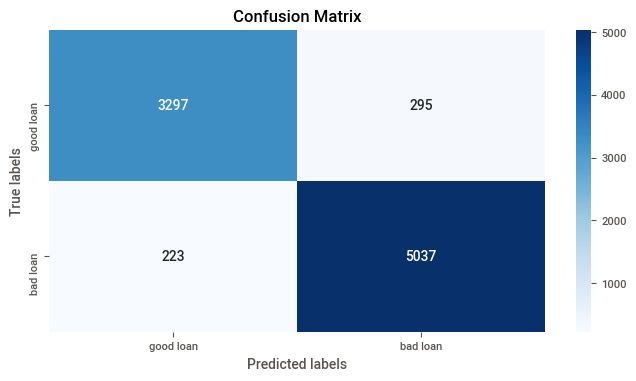

In [41]:
rf_clf.fit(x_train, y_train)
rf_y_pred = rf_clf.predict(x_test)
accuracy, precision, recall, f1, roc_auc = model_performance(y_test, rf_y_pred, classes=['good loan', 'bad loan'], title='Confusion Matrix')

From the classification report above, we could see the best random forest classifier model achieve 94.15% of accuracy. In our problem, accuracy is not the best metric to evaluate the model because false negative is important in our case. Here are some other evaluation metric to look at. For the bad loan:

1. Precision: When loans are predicted to be bad they are bad 94% of the time
2. Recall: Of all the true bad loans, this model identified 96% of them
3. F1 score: The harmonic-mean of the precision​ and recall, 95% for bad loans

For simplicity, we will use f1 score to evaluate the model as f1 score consider the precision and recall. We could use recall also but since we have more bad loan in our training data, the model may has more bias toward bad loan. The best random forest classifier model achieve 95.11% of f1 score. It's quite a good model, WELL DONE :)

In addition, with our classification problems where false negative are a lot more expensive than false positive, we may want to have a model with a high recall rather than high precision. Although this model is good at predicting bad loan, but it may cause by the imbalanced dataset which the bad loan is slightly more than the good loan.

Next, let's us look at the feature importances generated by the random forest classifier model.

In [42]:
def plot_feature_importance(importance, names, model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    #Define size of bar plot
    plt.figure(figsize = (8, 4))
    #Plot Searborn bar chart
    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


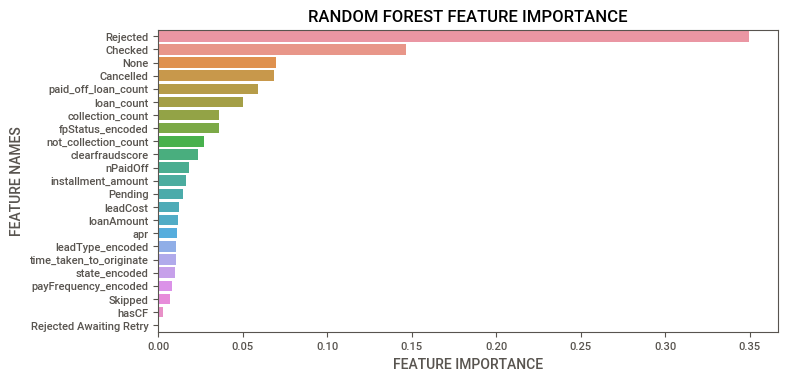

In [43]:
plot_feature_importance(rf_clf.feature_importances_, x_train.columns, 'RANDOM FOREST ')

From the graph above, we could see that some payment status such as rejected, checked, cancelled, and none has high impact on our model. This is what I ignore in my EDA step because I think that the loan with a longer payment period or higher payment frequency will have a larger value. For example, loan with 1 year of payment period will definetely has lower value in the payment status compare to the loan with 5 year of payment period. So it is better if we know the total payment value and we can normalize them. But the result shows that maybe my hypothesis is wrong. There are still important.

Other than that, we could see that the result is somehow matches with some of the quick insights in our EDA step.

1. The clearfraudscore is logically a very importance feature but due to the lower in the bad loan but due to the overlapping, we can't really conclude by only using it.
2. Loan with higher number of paid off loan is usually a good loan. Hence, it's an important feature to look at.
3. Loan that has a rejected first payment usually has a higher probability to become a bad loan. It's also an important feature to look at.

### Boosting (XGBoost)

Next, we repeat the same step using XGBoost Classifier to see the performance using boosting technique.

In [44]:
from xgboost import XGBClassifier


xgb_clf = XGBClassifier(eval_metric='logloss', random_state=0)
print("XGBoost training roc_auc_score: ", round(cross_val_score(xgb_clf, x_train, y_train, scoring='roc_auc', cv=10).mean() * 100, 2), "%")

XGBoost training roc_auc_score:  98.9 %


In [45]:
xgb_params = {
    'n_estimators': [int(x) for x in range(50, 500, 50)],
    "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "colsample_bytree": [0.3, 0.4, 0.5, 0.7]
}


xgb_clf = XGBClassifier(eval_metric='logloss', random_state=0)
xgb_random_cv = RandomizedSearchCV(estimator=xgb_clf, param_distributions=xgb_params, n_iter=10, cv=5, verbose=2, random_state=0, n_jobs=-1)
xgb_random_cv.fit(x_train, y_train)
xgb_random_cv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0.2, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=8, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [46]:
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bynode=1, colsample_bytree=0.3, eval_metric='logloss',
                        gamma=0.1, gpu_id=-1, importance_type='gain',
                        interaction_constraints='', learning_rate=0.2, max_delta_step=0,
                        max_depth=6, min_child_weight=7, missing=np.nan,
                        monotone_constraints='()', n_estimators=300, n_jobs=8,
                        num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
                        scale_pos_weight=1, subsample=1, tree_method='exact',
                        validate_parameters=1, verbosity=None)

print("XGBoost best training roc_auc_score: ", round(cross_val_score(xgb_clf, x_train, y_train, scoring='roc_auc', cv=10).mean() * 100, 2), "%")

XGBoost best training roc_auc_score:  98.89 %


Accuracy:  94.85 %
Precison:  95.56 %
Recall:  95.78 %
F1 Score:  95.67 %
ROC_AUC:  94.63 %

Model Report: 
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94      3592
         1.0       0.96      0.96      0.96      5260

    accuracy                           0.95      8852
   macro avg       0.95      0.95      0.95      8852
weighted avg       0.95      0.95      0.95      8852

Confusion Matrix: 


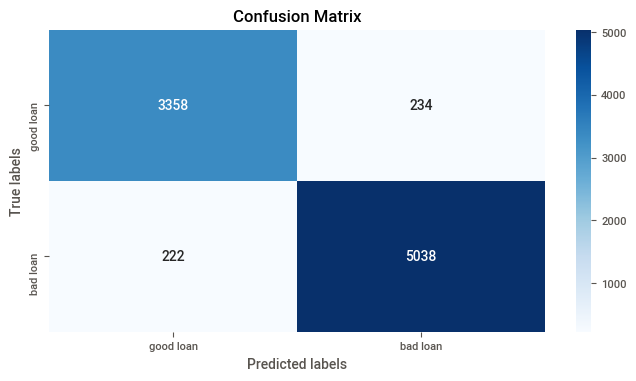

In [47]:
xgb_clf.fit(x_train, y_train)
xgb_y_pred = xgb_clf.predict(x_test)
accuracy, precision, recall, f1, roc_auc = model_performance(y_test, xgb_y_pred, classes=['good loan', 'bad loan'], title='Confusion Matrix')

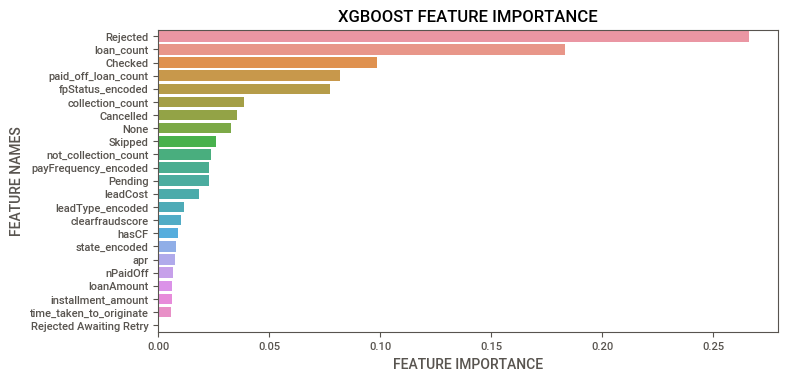

In [48]:
plot_feature_importance(xgb_clf.feature_importances_, x_train.columns, 'XGBOOST ')

From all the steps above, we could see that performance using XGBoost Classifier is almost the same with the Random Forest Classfifier. Both of them achieve a 95% of f1 score. But from the feature importance graph, we could see that XGBoost Classifier has weighted the features quite differently compare to the Random Forest Classifier. For me, I think that XGBoost's feature importance makes more sense.

Lastly, we quickly test to solve the probem using Decision Tree Algorithm.

Logistic Regression training roc_auc_score:  91.42 %
Accuracy:  92.04 %
Precison:  93.71 %
Recall:  92.83 %
F1 Score:  93.27 %
ROC_AUC:  91.85 %

Model Report: 
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      3592
         1.0       0.94      0.93      0.93      5260

    accuracy                           0.92      8852
   macro avg       0.92      0.92      0.92      8852
weighted avg       0.92      0.92      0.92      8852

Confusion Matrix: 


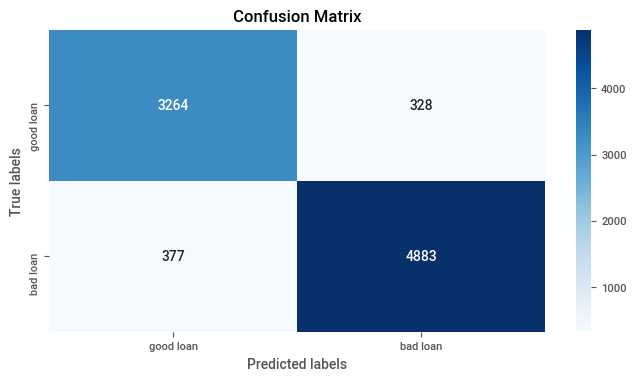

In [49]:
from sklearn.tree import DecisionTreeClassifier


dt_clf = DecisionTreeClassifier(random_state=0)
print("Logistic Regression training roc_auc_score: ", round(cross_val_score(dt_clf, x_train, y_train, scoring='roc_auc', cv=10).mean() * 100, 2), "%")
dt_clf.fit(x_train, y_train)
dt_y_pred = dt_clf.predict(x_test)
accuracy, precision, recall, f1, roc_auc = model_performance(y_test, dt_y_pred, classes=['good loan', 'bad loan'], title='Confusion Matrix')

From the result above, we could only achieve 93.27% of f1 score using Decision Tree Algorithm. (95% of f1 score both of our ensemble techniques) Hence, we can conclude that ensemble learning definitely perform better in our cases.

# Conclusion

In this assessment, we achieved 95% F1 score in predicting loans that have the high probability of being default based on their financial information and payment history using ensemble learning such as bagging technique like Random Forest and boosting technique like XGBoost. Ensemble learning algorithm helps to improve machine learning model performance by combining several models that allow the production of better predictive performance compared to a single model. Moreover, in our problem, false negative is more expensive than false positive. Hence we have to decide the metric to evaluate the model carefully. In our cases, we used f1 score.

Based on the feature importance generated, we can conclude that the number of payment status such as Rejected, Checked, Cancelled, and None, as well as the number off loan, number of paid off loan, first payment status, and maybe clearfraudscore have higher impact on our model. Hence, these are some important features to look at when predicting the loan status. The lender could also use it as a validation critiria in approval process. 

# Future Works

1. Collect more data or use upsampling or downsampling techniques to deal with the imbalanced dataset.

2. Try different model like Logistic Regression or SVM. But more transformations have to be done because skewed data will affect the performance in these model as describe previously. We could try deep learning model to further increase classification performance but deep learning model is just like a black box and is uninterpretable. Usually in busness context, we would like our model to be interpretable.

3. Use more information provided in the clarity_underwriting_variables.csv file. This file provides lots of information, maybe some of them are important and useful to us. Since I am not an expert in this area, I decided to use only the clearfraudscore in this file to avoid curse of dimensionality. But we still can use all of them if we want.

Time spent: 3 - 4 days